In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

Maximum may give us the one value that is the highest which may be an outlier and not very useful. However, the 90th percentile AQI would be useful because it indicates the value where 90% of the sample lies below. This is useful as it gives us a large value where 90% of the sample lies below it and can rule out outliers. When the difference between the 90th percentile AQI and the Max AQI is very large compared to the difference between the 90th percentile AQI and median AQI, this means that the Max AQI is an outlier.

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county['Date']).dt.month.astype(int)
daily_county['Day'] = pd.to_datetime(daily_county['Date']).dt.day.astype(int)


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [7]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [8]:
epa_data_CA = {}
for key in epa_data:
    if key != 'annual_county_aqi' and key != 'aqs_sites':
        epa_data_CA[key] = epa_data[key].query('`State Name` == "California"')
    

epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [9]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [10]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
ca_aqi = epa_data_CA.get('daily_county_aqi')
ca_aqi['Site Number'] = ca_aqi['Defining Site'].str.split('-').str.get(2).astype(int)
ca_aqi = ca_aqi.drop(columns=['Defining Parameter', 'Number of Sites Reporting'])
sites = epa_data.get('aqs_sites').query('`State Name` == "California"').iloc[:,:5]
sites['State Code'] = sites['State Code'].astype(int)
epa_data_CA_merged = ca_aqi.merge(sites, how='inner', on=['State Code', 'County Code', 'Site Number'])
epa_data_CA_merged = epa_data_CA_merged[cols].dropna().drop_duplicates()
epa_data_CA_merged

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935
2,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935
3,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935
4,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935
...,...,...,...,...,...,...,...,...,...
19220,California,Yolo,12,11,25,Good,06-113-1003,38.661210,-121.732690
19221,California,Yolo,12,16,19,Good,06-113-1003,38.661210,-121.732690
19222,California,Yolo,12,20,73,Moderate,06-113-1003,38.661210,-121.732690
19223,California,Yolo,12,23,49,Good,06-113-1003,38.661210,-121.732690


In [11]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [12]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
columns = ['District', 'Route', 'County', 'Descriptn', 'AADT', 'Latitude', 'Longitude']
traffic_data['AADT'] = traffic_data['Back_AADT'].replace(" ", 0).astype(int) + traffic_data['Ahead_AADT'].replace(" ", 0).astype(int)
traffic_data['Lat_S_or_W'] = traffic_data['Lat_S_or_W'].replace('Left Skipped - Input PM on Right Ind. Alignment', np.nan).astype(float)
traffic_data['Lon_S_or_W'] = traffic_data['Lon_S_or_W'].replace('Left Skipped - Input PM on Right Ind. Alignment', np.nan).astype(float)
traffic_data['Lat_N_or_E'] = traffic_data['Lat_N_or_E'].replace('Right Skipped - Input PM on Left Ind. Alignment', np.nan).astype(float)
traffic_data['Lon_N_or_E'] = traffic_data['Lon_N_or_E'].replace('Right Skipped - Input PM on Left Ind. Alignment', np.nan).astype(float)
traffic_data_cleaned = traffic_data.dropna().rename(columns={'Lon_S_or_W':'Longitude', 'Lat_S_or_W':'Latitude'})[columns]

traffic_data_cleaned

,District,Route,County,Descriptn,AADT,Latitude,Longitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,38.759843,-123.518503
1,1,1,MEN,NORTH LIMITS GUALALA,7100,38.770046,-123.531890
2,1,1,MEN,FISH ROCK ROAD,6200,38.803549,-123.585411
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,38.903973,-123.691513
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,38.910913,-123.692410
...,...,...,...,...,...,...,...
7115,12,605,ORA,"SEAL BEACH, JCT RTE 22",46100,33.778633,-118.091474
7116,12,605,ORA,JCT. RTE. 405,212200,33.784414,-118.091768
7117,12,605,ORA,"LOS ALAMITOS, KATELLA AVENUE",326800,33.802799,-118.082030
7118,12,605,ORA,ORANGE/LOS ANGELES COUNTY LINE,170000,33.806140,-118.081547


In [13]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [14]:
order = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long', 'Descriptn', 'AADT']
copy_epa_data_CA_merged = epa_data_CA_merged.copy()
gpd_epa = gpd.GeoDataFrame(copy_epa_data_CA_merged, geometry=gpd.points_from_xy(epa_data_CA_merged['Longitude'], epa_data_CA_merged['Latitude']))
gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned['Longitude'], traffic_data_cleaned['Latitude']))
gpd_epa_traffic = gpd_epa.sjoin_nearest(gpd_traffic, how='inner').rename(columns={'Latitude_left':'Site Lat','Longitude_left':'Site Long','Latitude_right':'Traffic Lat','Longitude_right':'Traffic Long'})[order]
gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
1,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
2,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
3,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
4,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300


In [15]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [16]:
states = epa_data.get('annual_county_aqi')['State'].unique()
us_states = np.delete(states, [7,9,40,48])
annual_aqi = epa_data.get('annual_county_aqi')
filtered_aqi = annual_aqi[(annual_aqi['Year']==2020) & (annual_aqi['State'].isin(us_states))]
worst_median_aqis = filtered_aqi.groupby('State')['Median AQI'].agg(np.mean).sort_values(ascending=False).rename('Average Median AQI')[:10]
worst_max_aqis = filtered_aqi.groupby('State')['Max AQI'].agg(np.mean).sort_values(ascending=False).rename('Average Max AQI')[0:10]


print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

np.round(list(worst_max_aqis), 2)

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64


array([430.35, 334.42, 286.98, 238.23, 197.86, 196.67, 196.67, 137.42,
       133.  , 124.75])

In [17]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

California, Arizona, Connecticut, and Nevada are the states that are in both the top 10 lists. I think states like California, Arizona, and Nevada are in both these lists because of their large and growing population which causes a lot of autombile and industrial pollution. I think Conneticut is also in both list because of their high levels of ozone pollution.

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [18]:
days_with_AQI = filtered_aqi.groupby('State')['Days with AQI'].agg(np.mean).sort_values()


days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [19]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [20]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [21]:
county_to_missing_dates = {}
ca_daily_data = epa_data_CA.get('daily_county_aqi')
county_list = ca_annual_data[ca_annual_data['Days with AQI'] != 366]['County']
days_in_year = ca_daily_data[ca_daily_data['county Name'] == 'Alameda']['Date']

for county in county_list:
    county_dates = ca_daily_data[ca_daily_data['county Name'] == county]['Date']
    county_to_missing_dates[county] = list(days_in_year[days_in_year.isin(county_dates)==False])
    
county_to_missing_dates

{'Amador': ['2020-01-04',
  '2020-01-05',
  '2020-01-06',
  '2020-01-07',
  '2020-08-24',
  '2020-10-17',
  '2020-10-18'],
 'Calaveras': ['2020-06-04', '2020-09-21'],
 'Del Norte': ['2020-01-15',
  '2020-01-16',
  '2020-01-17',
  '2020-01-18',
  '2020-01-20',
  '2020-01-21',
  '2020-01-23',
  '2020-03-14',
  '2020-03-15',
  '2020-04-22',
  '2020-04-23',
  '2020-04-25',
  '2020-04-26',
  '2020-04-28',
  '2020-04-29',
  '2020-05-01',
  '2020-05-02',
  '2020-05-04',
  '2020-05-05',
  '2020-05-07',
  '2020-05-08',
  '2020-05-10',
  '2020-05-11',
  '2020-05-13',
  '2020-05-14',
  '2020-05-16',
  '2020-05-17',
  '2020-05-19',
  '2020-05-20',
  '2020-05-22',
  '2020-05-23',
  '2020-05-25',
  '2020-05-26',
  '2020-05-28',
  '2020-05-29',
  '2020-05-31',
  '2020-06-01',
  '2020-06-02',
  '2020-06-03',
  '2020-06-04',
  '2020-06-05',
  '2020-06-06',
  '2020-06-07',
  '2020-06-08',
  '2020-06-09',
  '2020-06-10',
  '2020-06-11',
  '2020-06-12',
  '2020-06-13',
  '2020-06-14',
  '2020-06-15',
  '2

In [22]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

There are key missing dates in common between the counties that have mssing AQI data. For example, 2020-02-29 is a missing day for Lake, Plumas, and Trinity counties. This may be because 2020-02-29 is a leap day and only added to leap years. For this reason, counties such as Lake, Plumas, and Trinity may decide not to record the AQI on this day. Some key missing dates can also be found between Del Norte and Trinity. Both have a good chunk missing from their month of Juky. Both counties have missing days ranging from 2020-07-01 to 2020-07-14. Wildfire season may have affected these two counties so much that there was no monitoring for these days. The two counties that have the most missing days are Del Norte and Trinity. One reason why there might be so many missing days for these two counties may be because there might not be a reliable AQI monitoring stations. Del Norte and Trinity are very rural areas and may not have the consistent technology.

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [23]:
aqi_per_month = epa_data.get('daily_county_aqi').groupby('Month')['AQI'].agg(np.mean)
aqi_per_month_CA = epa_data.get('daily_county_aqi').query('`State Name` == "California"').groupby('Month')['AQI'].agg(np.mean)

print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [24]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

Something that is interesting in aqi_per_month_CA is that the average AQI per month across California is higher than the average AQI per month across the US for all months. This tells us that the overall average AQI in California is higher than the national average all throughout the year. This reasoning for this may be due to to large population in US and thus more automobile pollution throughout the year. Another reason for this is due to the California wildfires that ravage the state throughout the year. We can see espcially high average AQI for California from August-October which are part of the wildfire seasons.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

Based on the AQI pattern in the year 2020, if we were to model the AQI over the last 10 years, with the the average AQI per year being the same, our parametric function $f(x)$ would use a sinusoidal function. If the average AQI per year is the same as the pattern in 2020, the average AQI will increase until a certain peak and fall back down during that year and then reapats the same up and down motion for future years, thus following the form of a sinusoidal function. If we see a linear increase in the average AQI per year over the last 10 years instead, then the parametric function $g(x)$ we would use is $f(x)$ multiplied by a linear function. This is because our average AQI would still keep the form of a sinusoidal function increasing and then decreasing due to wildfire season, but we would multiply this by a linear function since there is a linear increase in average AQI per year.

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [25]:
def bucket_data(table, aggfunc, resolution):
    table = table.copy()
    table['lat_bucket'] = pd.cut(table['Latitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Latitude'].min(), table['Latitude'].max(), resolution, endpoint=False),2))
    table['long_bucket'] = pd.cut(table['Longitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Longitude'].min(), table['Longitude'].max(), resolution, endpoint=False),2))
    pivoted = pd.pivot_table(data=table, values='AQI', index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)
    return pivoted 

bucket_data(epa_data_CA_merged, np.mean, 5)

long_bucket,-124.2,-122.28,-120.36,-118.44,-116.52
lat_bucket,,,,,
32.58,NaN,NaN,65.317391,87.059645,67.955508
34.41,NaN,50.221983,67.597970,74.442308,58.294118
36.25,42.792276,51.489882,81.094254,74.704918,NaN
38.08,38.934803,53.699484,48.977778,NaN,NaN
39.92,38.790792,55.207065,NaN,NaN,NaN


In [26]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

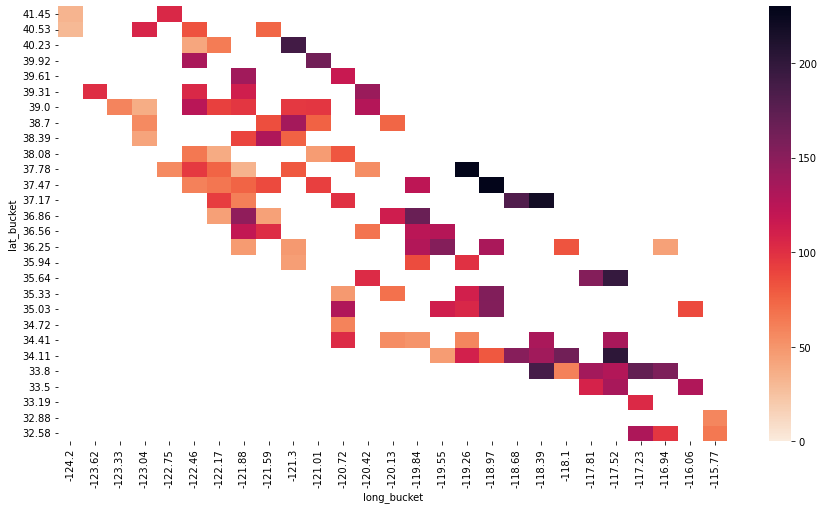

In [27]:
sept_ca = epa_data_CA_merged.query('Month == 9')
heatmap_data = bucket_data(sept_ca, np.median, 30)


#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [28]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The dark areas on the bottom right with coordinates (lat_bucket= 34.41, long_bucket = -117.23 )correspond to northern Los Angeles County and the San Gabriel Mountains. This heatmap makes sense because the dark spots represent the highest median AQI and their location in California in September 2020. In Spetmeber 2020, the Bobcat Wildfire ravaged northern Los Angeles and the San Gabriel Mountains which can be seen as the bottom right dark spots. There are also very dark spots near the middle of the map with coordinates (lat_bucket=37.47, long_bucket=-118.97) which corresponds to Fresno County Mountains. This heatmap makes sense since during September 2020, Fresno County expereinced the Creek Fire, the one of the largest fires in California history.

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [29]:
epa_data_CA_merged_copy = epa_data_CA_merged.copy()
ozone = epa_data_CA.get('daily_ozone')
wind = epa_data_CA.get('daily_temp').query('`Units of Measure` == "Knots"')
temp = epa_data_CA.get('daily_wind')

epa_data_CA_merged_copy['Site Num'] = epa_data_CA_merged_copy['Defining Site'].str.split('-').str.get(2).astype(int)
epa_data_CA_merged_copy = epa_data_CA_merged_copy.rename(columns={'county Name':'County Name'})[['State Name','County Name','Defining Site','Site Num','Month','Day','Latitude','Longitude', 'AQI']]

ozone['Month'] = pd.to_datetime(ozone['Date Local']).dt.month.astype(int)
ozone['Day'] = pd.to_datetime(ozone['Date Local']).dt.day.astype(int)
wind['Month'] = pd.to_datetime(wind['Date Local']).dt.month.astype(int)
wind['Day'] = pd.to_datetime(wind['Date Local']).dt.day.astype(int)
temp['Month'] = pd.to_datetime(temp['Date Local']).dt.month.astype(int)
temp['Day'] = pd.to_datetime(temp['Date Local']).dt.day.astype(int)

ozone = ozone[['State Name', 'County Name', 'Site Num','Month', 'Day', '1st Max Value']]
wind = wind[['State Name', 'County Name', 'Site Num','Month', 'Day', '1st Max Value']]
temp = temp[['State Name', 'County Name', 'Site Num','Month', 'Day', '1st Max Value']]

epa_data_CA_merged_ozone = epa_data_CA_merged_copy.merge(ozone, how='inner', on=['State Name','County Name','Site Num','Month', 'Day']).rename(columns={'1st Max Value':'ozone'}).drop_duplicates()
epa_data_CA_merged_ozone_wind = epa_data_CA_merged_ozone.merge(wind, how='inner', on=['State Name','County Name','Site Num','Month', 'Day']).rename(columns={'1st Max Value':'Wind'}).drop_duplicates()
epa_data_CA_merged_ozone_wind_temp = epa_data_CA_merged_ozone_wind.merge(temp, how='inner', on=['State Name','County Name','Site Num','Month', 'Day']).rename(columns={'1st Max Value':'Temp'}).drop_duplicates()


def bucket_data_ozone(table, aggfunc, resolution):
    table = table.copy()
    table['lat_bucket'] = pd.cut(table['Latitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Latitude'].min(), table['Latitude'].max(), resolution, endpoint=False),2))
    table['long_bucket'] = pd.cut(table['Longitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Longitude'].min(), table['Longitude'].max(), resolution, endpoint=False),2))
    pivoted = pd.pivot_table(data=table, values='ozone', index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)
    return pivoted 

def bucket_data_wind(table, aggfunc, resolution):
    table = table.copy()
    table['lat_bucket'] = pd.cut(table['Latitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Latitude'].min(), table['Latitude'].max(), resolution, endpoint=False),2))
    table['long_bucket'] = pd.cut(table['Longitude'], bins=resolution, right=False, precision=2, labels=np.round(np.linspace(table['Longitude'].min(), table['Longitude'].max(), resolution, endpoint=False),2))
    pivoted = pd.pivot_table(data=table, values='Wind', index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)
    return pivoted 

epa_data_CA_merged_ozone_wind_temp

,State Name,County Name,Defining Site,Site Num,Month,Day,Latitude,Longitude,AQI,ozone,Wind,Temp
0,California,Amador,06-005-0002,2,1,1,38.342606,-120.764426,25,0.027,4.4,58.8
1,California,Amador,06-005-0002,2,1,2,38.342606,-120.764426,18,0.019,3.6,59.5
2,California,Amador,06-005-0002,2,1,3,38.342606,-120.764426,19,0.020,3.9,61.5
3,California,Amador,06-005-0002,2,1,8,38.342606,-120.764426,23,0.025,3.1,49.5
4,California,Amador,06-005-0002,2,1,9,38.342606,-120.764426,25,0.027,2.7,46.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,California,Yolo,06-113-0004,4,12,27,38.534450,-121.773400,20,0.022,7.7,54.7
8869,California,Yolo,06-113-0004,4,12,28,38.534450,-121.773400,33,0.036,9.2,54.7
8870,California,Yolo,06-113-0004,4,12,29,38.534450,-121.773400,28,0.030,12.2,61.5
8871,California,Yolo,06-113-0004,4,12,30,38.534450,-121.773400,39,0.023,10.4,55.6


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

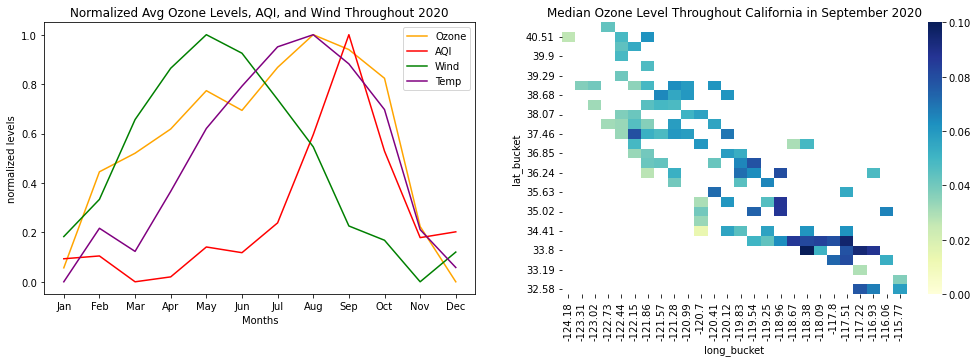

In [30]:
ozonemap_data = bucket_data_ozone(epa_data_CA_merged_ozone.query('Month == 9'), np.median, 30)
windmap_data = bucket_data_wind(epa_data_CA_merged_ozone_wind.query('Month == 9'), np.median, 30)
avg_monthly_ozone = epa_data_CA_merged_ozone.groupby('Month').mean()['ozone']
avg_monthly_wind = epa_data_CA_merged_ozone_wind.groupby('Month').mean()['Wind']
avg_monthly_temp = epa_data_CA_merged_ozone_wind_temp.groupby('Month').mean()['Temp']
normalized_avg_ozone = (avg_monthly_ozone - avg_monthly_ozone.min())/(avg_monthly_ozone.max() - avg_monthly_ozone.min())
normalized_avg_aqi = (aqi_per_month_CA - aqi_per_month_CA.min())/(aqi_per_month_CA.max() - aqi_per_month_CA.min())
normalized_avg_wind = (avg_monthly_wind - avg_monthly_wind.min())/(avg_monthly_wind.max() - avg_monthly_wind.min())
normalized_avg_temp = (avg_monthly_temp - avg_monthly_temp.min())/(avg_monthly_temp.max() - avg_monthly_temp.min())

f, axes = plt.subplots(1, 2, figsize=(17,5))
sns.heatmap(ozonemap_data, vmin=0, vmax=0.1, ax=axes[1], cmap="YlGnBu").invert_yaxis()
axes[1].set_title('Median Ozone Level Throughout California in September 2020')
axes[0].set_title('Ozone Map of California in September 2020')
axes[0].plot(avg_monthly_ozone.index , normalized_avg_ozone, label='Ozone', color='orange')
axes[0].plot(aqi_per_month_CA.index , normalized_avg_aqi, label='AQI', color='red')
axes[0].plot(aqi_per_month_CA.index , normalized_avg_wind, label='Wind', color='green')
axes[0].plot(aqi_per_month_CA.index , normalized_avg_temp, label='Temp', color='purple')
axes[0].set_xlabel('Months')
axes[0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
axes[0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axes[0].set_ylabel('normalized levels')
axes[0].set_title('Normalized Avg Ozone Levels, AQI, and Wind Throughout 2020')
axes[0].legend();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

We were curious on how the ozone levels and wind speed may have looked in 2020 and especially in September 2020 so we can compare to the average AQI in 2020. To do this, we merged the daily_ozone DataFrame and daily_wind DataFrame to our existing epa_merged_CA DataFrame which already has the latitudes and longitudes of different locations. With the data we need, we first wanted to visualize the average ozone levels and average wind speeds throughout the months of 2020. By graphing a line plot of the normalized average ozone, normalized average wind speed, and normalized average AQI over the months of 2020 in California, we can compare the the three over time. As can be seen on the first graph, the levels for normalized avg ozone levels and normalized avg wind speeds are already increasing since January, but for AQI it lags behind and doesn't really increase until July. Ozone and AQI increase a good amount until September, then they both start to drop off and decrease until December. However starting July, is when wind temperatures start dropping rapidly and starts increasing late September. Although there is a lag in the AQI, the all three show a positive correlation until July, when wildfire season starts. After July, ozone and AQI are still positively correlated, but wind speed become negatively correlated with ozone and AQI. This makes sense since wildfire season will increase AQI and air pollutants such as ozone levels, but should decrease the wind speed due to thick atmosphere created by wildfires. The second visual we created to understand the relationship between ozone and AQI is by creating a heatmap for ozone. We tried creating a heatmap for windspeed but was unable to overlay two heatmaps ontop of one another. The windspeed heatmap also did not contain enough variation in locations and was just a few blobs that we think would not add much value. To create the ozone heatmap similar to what we did in 6a and 6b, we created a function that created a pivot table of the coordinate buckets and the median ozone level values. From what we can see from the ozone heatmap of California in September 2020, it is very similar to the AQI heat map of California in September 2020. Areas with high median AQI because of the wildfires such as LA and Fresno county have dark spots indicating high levels of ozone. This supports our idea that ozone level and AQI have a positive correlation. This makes sense as ground level ozone is a hazardous air pollutant that may be results of industrial production and wildfires. Due to the large amounts of California wildfires in Spetember 2020 (especially in LA and Fresno county) the ground level ozone levels will definitely be very high. Through our analysis and data visualizations, we can see clear correlation (whether that be positive or negative) between ozone level and wind speed with AQI especially during wildfire season. These correlations indicate that ozone level and windspeed may be good features to use in predicting AQI. Something we may want to look further into may be certain high-elevation locations and also their density. These can acquired through external datasets and may be good predictive features.

<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

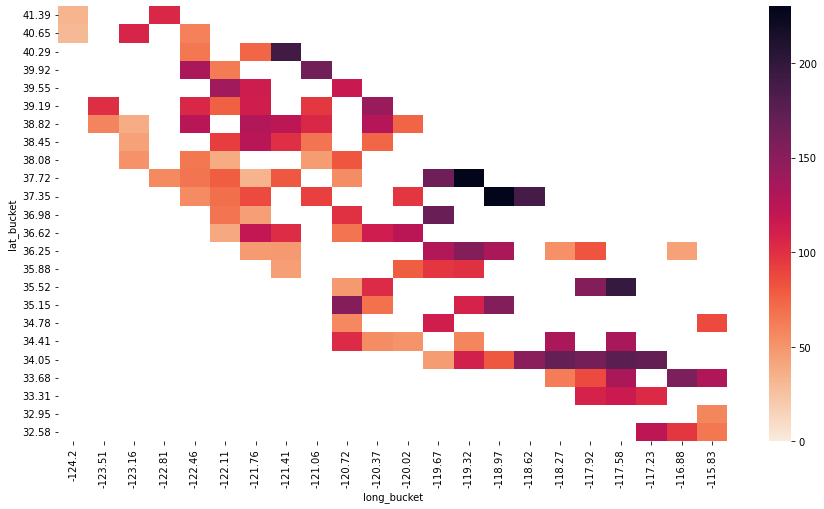

In [31]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [32]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    if pd.notnull(pivot_table.iloc[lat_bucket,lon_bucket]):
        return pivot_table.iloc[lat_bucket,lon_bucket]
    else:
        counter = 0
        sides = 0
        for a in range(1, pivot_table.shape[0] - lat_bucket):
            if pd.notnull(pivot_table.iloc[lat_bucket + a,lon_bucket]):
                counter += 1
                sides += pivot_table.iloc[lat_bucket + a,lon_bucket]
                break
        for b in range(1, lat_bucket + 1):
            if pd.notnull(pivot_table.iloc[lat_bucket - b,lon_bucket]):
                counter += 1
                sides += pivot_table.iloc[lat_bucket - b,lon_bucket]
                break
        for c in range(1, pivot_table.shape[1] - lon_bucket):
            if pd.notnull(pivot_table.iloc[lat_bucket,lon_bucket + c]):
                counter += 1
                sides += pivot_table.iloc[lat_bucket,lon_bucket + c]
                break
        for d in range(1, lon_bucket + 1):
            if pd.notnull(pivot_table.iloc[lat_bucket,lon_bucket - d]):
                counter += 1
                sides += pivot_table.iloc[lat_bucket,lon_bucket - d]
                break
        if counter >= 3:
            return sides/counter
        else:
            return np.nan

In [33]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

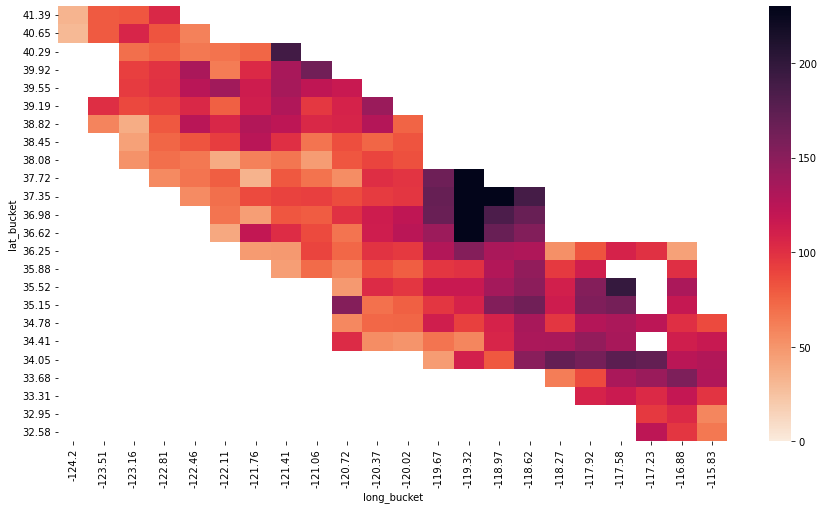

In [34]:
def fill_all(pivot_table):
    copy = pivot_table.copy()
    for r in range(copy.shape[0]):
        for c in range(copy.shape[1]):
            copy.iloc[r, c] = fill_bucket(heatmap_data, r, c)
    return copy

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   


In [35]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

Another way we can interpolate is by doing what we did above, but also to take into account the distance of the closest neighboring cell. For example, if Right is a valid direction, we will interpolate using the closest R cell, but we will also take into account how "close" this closest cell is by looking at the distance away from our current cell K. If the closest R cell is one cell away to the right of our current cell K, we will account for the AQI fully. However, if the closest R cell is instead 2 cells away, we will only take into account only 90% of the AQI value provided. In general, if the closest R cell is n cells away, we will take into account $(0.9)^{(n-1)}$ of the AQI value provided. We will then do this for all valid directions and interpolate by assigning K to the average the resulting AQI values for each direction. In summary, we can interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions by also taking into account the distance away from current cell K.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

A loss function we can use is to penalize wrong predictions from these 6 groups. We can look at the absolute distance squared of our predicted value and the actual value. We can do this by mapping {good : 1, moderate : 2, unhealthy sensitive groups : 3, unhealthy : 4, very unhealthy : 5, hazardous : 6}. If we predict an 'moderate' which is mapped to 2, and the actual is 'unhealthy' which is mapped to 4, our loss would be $(|2-4|)^2$. We will want to minimize this loss by looking the mean values across all data points. This is mean squared absolute distance error.

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

The 3 features that we will be using from the AQI dataset will be ozone levels, wind speed, and temperature. The external feature we will be using is AADT (annual average daily traffic) from the traffic dataset. We think ozone levels is very predictive of the AQI categories. We belive there is a very high correlation between particulate matter features such as ozone since AQI is directly based off these values. We will also be using wind speed as a feature because based off of the visualizations from their normalized values in the EDA above, we can see a negative correlation between wind speed and AQI which can be a predictive feature. The third feature we will be using from the AQI dataset is temperature. Temperature is a predictive feature since wildfires which cause high AQI levels would also shoot up the temperature of the specific location. The external feature we will be using is AADT from the traffic dataset which can be a good predictive feature. We hypothesize that places with high AQI levels during wildfire season usually means that location is experiencing a wildfire and AADT would be low due to everyone being evacuated. The model we are choosing to use is a decision tree since we are using multiple features to predict AQI category (categorical).

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [36]:
categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

def bin(array):
    predict_list = []
    for i in array:
        if (0 <= i < 51):
            predict_list.append(categories[0])
        elif (51 <= i < 101):
            predict_list.append(categories[1])
        elif (101 <= i < 151):
            predict_list.append(categories[2])
        elif (151 <= i < 201):
            predict_list.append(categories[3])
        elif (201 <= i < 301):
            predict_list.append(categories[4])
        elif (301 <= i):
            predict_list.append(categories[5])
    return np.array(predict_list)

epa_data_CA_merged_ozone_wind_temp_copy = epa_data_CA_merged_ozone_wind_temp.copy()
epa_data_CA_with_ext = gpd.GeoDataFrame(epa_data_CA_merged_ozone_wind_temp_copy, geometry=gpd.points_from_xy(epa_data_CA_merged_ozone_wind_temp['Longitude'], epa_data_CA_merged_ozone_wind_temp['Latitude']))
gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned['Longitude'], traffic_data_cleaned['Latitude']))
good_merged = epa_data_CA_with_ext.sjoin_nearest(gpd_traffic, how='inner').rename(columns={'Latitude_left':'Latitude','Longitude_left':'Longitude','Latitude_right':'Traffic Lat','Longitude_right':'Traffic Long'})
good_merged = good_merged[['State Name', 'County Name', 'Defining Site', 'Site Num', 'Month', 'Day', 'Latitude', 'Longitude', 'ozone', 'Wind', 'Temp', 'AADT', 'AQI']]
good_merged['ozone norm'] = (good_merged['ozone'] - good_merged['ozone'].min())/(good_merged['ozone'].max() - good_merged['ozone'].min())
good_merged['Wind norm'] = (good_merged['Wind'] - good_merged['Wind'].min())/(good_merged['Wind'].max() - good_merged['ozone'].min())
good_merged['Temp norm'] = (good_merged['Temp'] - good_merged['Temp'].min())/(good_merged['Temp'].max() - good_merged['Temp'].min())
good_merged['AADT norm'] = (good_merged['AADT'] - good_merged['AADT'].min())/(good_merged['AADT'].max() - good_merged['AADT'].min())
good_merged['AQI bins'] = bin(np.array(good_merged['AQI']))

features = good_merged[['ozone','Wind', 'Temp', 'AADT']]
targets = np.array(good_merged['AQI bins'])

features.head()

,ozone,Wind,Temp,AADT
0,0.027,4.4,58.8,15600
1,0.019,3.6,59.5,15600
2,0.020,3.9,61.5,15600
3,0.025,3.1,49.5,15600
4,0.027,2.7,46.9,15600


In [37]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [38]:
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeClassifier

def build_model(feature, target):
    decision_tree_model = DecisionTreeClassifier()
    return decision_tree_model.fit(feature, target)

In [39]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [40]:
categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

def predict(model, features):
    return model.predict(features)

In [41]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, targets, train_size = 0.7, random_state=40)

val_predict = predict(build_model(X_train, y_train), X_val)
mapping = {'good' : 1, 'moderate' : 2, 'unhealthy sensitive groups' : 3, 'unhealthy' : 4, 'very unhealthy' : 5, 'hazardous' : 6}

converted_predictions = np.array([mapping[val] for val in val_predict])
converted_actual = np.array([mapping[val] for val in y_val])

binary_error = 1 - np.sum(val_predict == y_val)/len(X_val) 
cv_error = np.mean((np.abs(converted_predictions - converted_actual))**2)

binary_error, cv_error

(0.1932833154698107, 0.34798142193640585)

In [47]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

In [48]:
# Using our previous merged dataframe in Q10 which includes external Traffic dataset, merge with sites dataset for elevation and land use. 

ca_sites = epa_data.get('aqs_sites').query('`State Name` == "California"')
ca_sites = ca_sites[['County Code','State Name', 'County Name', 'Site Number', 'Elevation', 'Land Use']]
internal_merged = good_merged.merge(ca_sites, how='inner', left_on=['State Name', 'County Name', 'Site Num'], right_on=['State Name', 'County Name', 'Site Number'])
land_use_map = {internal_merged['Land Use'].unique()[i]: i for i in range(len(internal_merged['Land Use'].unique()))}

internal_merged['Land Use Num'] = [land_use_map[val] for val in internal_merged['Land Use']]
internal_merged.head()

,State Name,County Name,Defining Site,Site Num,Month,Day,Latitude,Longitude,ozone,Wind,...,ozone norm,Wind norm,Temp norm,AADT norm,AQI bins,County Code,Site Number,Elevation,Land Use,Land Use Num
0,California,Amador,06-005-0002,2,1,1,38.342606,-120.764426,0.027,4.4,...,0.194245,0.085648,0.345263,0.021981,good,5,2,377.0,COMMERCIAL,0
1,California,Amador,06-005-0002,2,1,2,38.342606,-120.764426,0.019,3.6,...,0.136691,0.067130,0.352632,0.021981,good,5,2,377.0,COMMERCIAL,0
2,California,Amador,06-005-0002,2,1,3,38.342606,-120.764426,0.020,3.9,...,0.143885,0.074074,0.373684,0.021981,good,5,2,377.0,COMMERCIAL,0
3,California,Amador,06-005-0002,2,1,8,38.342606,-120.764426,0.025,3.1,...,0.179856,0.055556,0.247368,0.021981,good,5,2,377.0,COMMERCIAL,0
4,California,Amador,06-005-0002,2,1,9,38.342606,-120.764426,0.027,2.7,...,0.194245,0.046296,0.220000,0.021981,good,5,2,377.0,COMMERCIAL,0


In [49]:
# Initialize features and targets for baseline model.

base_features = internal_merged[['Temp','Elevation','County Code']]
base_targets = np.array(internal_merged['AQI bins'])

base_features.head()

,Temp,Elevation,County Code
0,58.8,377.0,5
1,59.5,377.0,5
2,61.5,377.0,5
3,49.5,377.0,5
4,46.9,377.0,5


In [50]:
# Build a random forest model using sklearn.

from pyspark.ml.classification import RandomForestClassifier

def build_model_forest(feature, target):
    random_forest_model = RandomForestClassifier()
    return random_forest_model.fit(feature, target)

In [51]:
# Creating a predict function for our model.

def predict_forest(model, features):
    return model.predict(features)

In [52]:
# Split our data into training and validation then find binary error and cv error of baseline model.

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(base_features, base_targets, train_size = 0.7, random_state=100)

val_predict_base = predict_forest(build_model_forest(X_train_base, y_train_base), X_val_base)
mapping_base = {'good' : 1, 'moderate' : 2, 'unhealthy sensitive groups' : 3, 'unhealthy' : 4, 'very unhealthy' : 5, 'hazardous' : 6}

converted_predictions_base = np.array([mapping_base[val] for val in val_predict_base])
converted_actual_base = np.array([mapping_base[val] for val in y_val_base])

binary_error_base = 1 - np.sum(val_predict_base == y_val_base)/len(X_val_base) 
cv_error_base = np.mean((np.abs(converted_predictions_base - converted_actual_base))**2)

binary_error_base , cv_error_base

(0.3576277241872097, 0.624151482672383)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

Although most high-elevation forests in California have not been subjected to fire suppression, human activities, and because trees at these high elevations are in wetter forests, higher-elevation forests are more prone to wildfires due to the increased effects global warming (measured with particulate matter concentrations such as ozone). We hypothesize there is a positive correlation between elevation and AQI levels in California due to the effects of global warming and thus higher threat of wildfires. Thus, features relating to elevation and wildfires such as: general location (county and site), exact location (latitude and longitude), day and month, elevation, ozone level, wind speed, temperature, wildfire data (avg acres burned), land use, AADT, and county population density can all be good predictive features of AQI levels/categories.

Our baseline model will use just three features relating to elevation that can affect AQI. These three features are elevation, temperature, and County Code. These three baseline features were chosen because it serves as good foundation relating to our hypothesis. 

Our baseline model will be a Random Forest Classifier because we are using mulitple features to predict AQI categories (categorical) and we want to avoid overfitting. The inputs are 'features' which are in the form of a DataFrame and represents our 𝑋  matrix and 'targets' a numpy array that corresponds to the AQI category for each of the data points in features and is essentially our  𝑦  vector. After predicting with this baseline model, we got a binary error of around 0.36. Using the loss function we created in question 10 which is essentailly mean squared absolute distance error, the cross-validation error that we got using this loss function on the validation set is around 0.6.

To improve our model, we can include additional features to better pinpoint certain elevations to better support our hypothesis. To do this, we will use additional features from our AQI dataset and external datasets such as the Traffic dataset and California WildFires dataset that have correlation to AQI levels. To implement new qualitative features into our random forest classifier, we will map numerical values to each qualitative variable. To see if our improved model has improved in accuracy, we will see if the binary error decreased. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

In [53]:
# External Dataset 1: Traffic Dataset which was already merged in previous parts

# External Dataset 2: Annual County Population Density in California 2020
# Cite: https://covid19.census.gov/datasets/USCensus::average-household-size-and-population-density-county/explore?showTable=true

pop_den = pd.read_csv('data/Average_Household_Size_and_Population_Density_-_County.csv')
pop_den_ca = pop_den.query('State == "California"')
pop_den_ca['NAME'] = pop_den_ca['NAME'].str.split(' County').str[0]
pop_den_ca = pop_den_ca.rename(columns={'NAME':'County Name', 'B01001_calc_PopDensity': 'Population Density (ppl per sq km)'})
pop_den_ca = pop_den_ca[['County Name', 'Population Density (ppl per sq km)']]
pop_den_ca.head()

,County Name,Population Density (ppl per sq km)
186,Alameda,860.757075
187,Alpine,0.599281
188,Amador,24.565345
189,Butte,53.575159
190,Calaveras,17.122606


In [54]:
# External Dataset 3: California Wildfire Data (AVG Acres Burned for Each County)
# Cite: https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020 

fire = pd.read_csv('data/California_Fire_Incidents.csv')
cal_fire = fire[fire['AcresBurned'].notna()]
cal_fire = cal_fire.groupby('Counties').agg(np.mean).reset_index().rename(columns={'Counties':'County Name', 'AcresBurned' : 'Avg Acres Burned'})
cal_fire = cal_fire.iloc[:, :2]
cal_fire.head()


,County Name,Avg Acres Burned
0,Alameda,199.593750
1,Alpine,0.000000
2,Amador,483.461538
3,Butte,2889.424242
4,Calaveras,120.363636


In [55]:
# Merge our dataframe from Q11a with the 2 external datasets to get a fully merged dataframe.

fully_merged = internal_merged.merge(pop_den_ca, how='inner', on='County Name').merge(cal_fire, how='inner', on='County Name')
fully_merged.head()

,State Name,County Name,Defining Site,Site Num,Month,Day,Latitude,Longitude,ozone,Wind,...,Temp norm,AADT norm,AQI bins,County Code,Site Number,Elevation,Land Use,Land Use Num,Population Density (ppl per sq km),Avg Acres Burned
0,California,Amador,06-005-0002,2,1,1,38.342606,-120.764426,0.027,4.4,...,0.345263,0.021981,good,5,2,377.0,COMMERCIAL,0,24.565345,483.461538
1,California,Amador,06-005-0002,2,1,2,38.342606,-120.764426,0.019,3.6,...,0.352632,0.021981,good,5,2,377.0,COMMERCIAL,0,24.565345,483.461538
2,California,Amador,06-005-0002,2,1,3,38.342606,-120.764426,0.020,3.9,...,0.373684,0.021981,good,5,2,377.0,COMMERCIAL,0,24.565345,483.461538
3,California,Amador,06-005-0002,2,1,8,38.342606,-120.764426,0.025,3.1,...,0.247368,0.021981,good,5,2,377.0,COMMERCIAL,0,24.565345,483.461538
4,California,Amador,06-005-0002,2,1,9,38.342606,-120.764426,0.027,2.7,...,0.220000,0.021981,good,5,2,377.0,COMMERCIAL,0,24.565345,483.461538


In [56]:
# Initialize the features and targets for our improved model which includes features from 
# additional features from AQI dataset and features from 3 external datasets (traffic, pop density, wildfires)

full_features = fully_merged[['County Code', 'Site Number', 'Latitude', 'Longitude', 'Month', 'Day', 'Elevation',
                              'ozone', 'Wind', 'Temp', 'Avg Acres Burned','Land Use Num','AADT', 
                              'Population Density (ppl per sq km)']]

full_targets = np.array(fully_merged['AQI bins'])

full_features.head()

,County Code,Site Number,Latitude,Longitude,Month,Day,Elevation,ozone,Wind,Temp,Avg Acres Burned,Land Use Num,AADT,Population Density (ppl per sq km)
0,5,2,38.342606,-120.764426,1,1,377.0,0.027,4.4,58.8,483.461538,0,15600,24.565345
1,5,2,38.342606,-120.764426,1,2,377.0,0.019,3.6,59.5,483.461538,0,15600,24.565345
2,5,2,38.342606,-120.764426,1,3,377.0,0.020,3.9,61.5,483.461538,0,15600,24.565345
3,5,2,38.342606,-120.764426,1,8,377.0,0.025,3.1,49.5,483.461538,0,15600,24.565345
4,5,2,38.342606,-120.764426,1,9,377.0,0.027,2.7,46.9,483.461538,0,15600,24.565345


In [57]:
# With our random forest classifier build model and predict functions from Q11a, we can build and predict with 
# our improved model which uses more features from our AQI dataset and uses other features from external datasets.
# After building the model, we will split our data into training and validation sets. We then predict then find the
# binary error and cv error to access the new model.

X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(full_features, full_targets, train_size = 0.8, random_state=11)

val_predict_full = predict_forest(build_model_forest(X_train_full, y_train_full), X_val_full)
mapping_full = {'good' : 1, 'moderate' : 2, 'unhealthy sensitive groups' : 3, 'unhealthy' : 4, 'very unhealthy' : 5, 'hazardous' : 6}

converted_predictions_full = np.array([mapping_full[val] for val in val_predict_full])
converted_actual_full = np.array([mapping_full[val] for val in y_val_full])

binary_error_full = 1 - np.sum(val_predict_full == y_val_full)/len(X_val_full) 
cv_error_full = np.mean((np.abs(converted_predictions_full - converted_actual_full))**2)

binary_error_full, cv_error_full

(0.10816657652785289, 0.1584640346133045)

In [58]:
# # A visualization of the first tree from our random forest. May take a while to load.
# # Running running this cell I can't export the file.
# # I am therefore commenting this cell out for now.

# from sklearn.tree import export_graphviz
# import graphviz

# tree1 = export_graphviz(build_model_forest(X_train_full, y_train_full).estimators_[0],
#                 out_file = None,
#                 feature_names= X_train_full.columns,
#                 class_names = ['good', 'moderate', 'unhealthy sensitive groups', 'unhealthy','very unhealthy', 'hazardous'],
#                 filled = True,
#                 rounded = True,
#                 special_characters = True)

# graph = graphviz.Source(tree1, format='png')
# graph

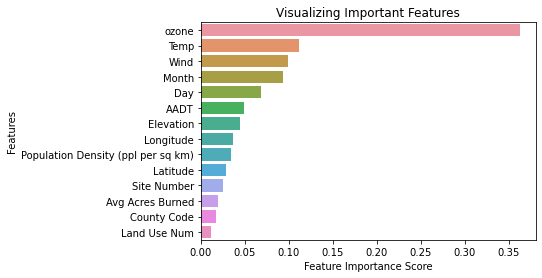

In [59]:
# Visualization of the ranking the importance of all our features.

clf = RandomForestClassifier()

clf.fit(X_train_full, y_train_full)
feature_imp = pd.Series(clf.feature_importances_,index=X_val_full.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

By adding additional features from our AQI dataset and features from 3 external datasets (traffic, population density, wildfires) we were able to drastically improve our model. Our hypothesis was that there is a positive correlation between elevation and AQI levels in California due to the effects of global warming and thus higher threat of wildfires. Our initial baseline model which only used 3 features (temperature, county, and elevation) was not enough and did not fit well due to high bias. To better pinpoint locations of certain elevations to support our hypothesis and fit our model, we added additional features such as site number, lat/long, month and day, ozone levels, wind speed, temperature, avg acres burned from wildfires, land use, AADT, and population density. With our improved model, we got a binary error of around 0.11 which is a lot lower than our baseline model which had a binary error of around 0.36. Utiliziing our loss function form Q9, our improved model resulted in a cv error on the validation set of around 0.16 which is also a lot lower than the cv error of the baseline model which was around 0.6. By comparing the validation errors (binary and cv), we can clearly see that our new model has improved from our baseline model by a good margin.

This analysis and modeling has definitely helped us successfully answer our research question and evaluate our hypothesis. We hypothesized that there is a positive correlation between elevation and AQI levels in California due to the effects of global warming and thus higher threat of wildfires. By adding additional features from the AQI dataset and from external datasets to make our model more refined towards our hypothesis, we saw huge improvements in the new model's performance to predict AQI levels/categories. This improvement shows that by refining our model towards our hypothesis, our validation of our hypothesis also increases.

In summary, our hypothesis seems to be correct due to the improvemnts we see in our model when we refine it towards the hypothesis. Thus, features relating to elevation and wildfires such as: general location (county and site), exact location (latitude and longitude), day and month, elevation, ozone level, wind speed, temperature, wildfire data (avg acres burned), land use, AADT, and county population density can all be good predictive features of AQI levels/categories. By intuition these features make sense. Certain locations in California are more prone to wildfires (Rancho Palos Verdes, Calabasas, La Cañada Flintridge) because of climate change and past wildfire experience. These locations are usually high in elevation. By looking at these features plus more specific features such as wind speed, AADT, population density, etc (features in our model), we can better predict AQI levels/categories.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [60]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q4a results: All test cases passed!

q4i results: All test cases passed!

q5a results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q8a results: All test cases passed!

q8b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [61]:
# Save your notebook first, then run this cell to export your submission.
grader.export()